# Regresion lineal sobre coste de seguro médico.

Instrucciones

Predecir el coste del seguro médico de una persona.

La importante compañía de seguros 4Geeks Insurance S.L. quiere calcular, en función de los datos fisiológicos de sus clientes, cuál va a ser la prima (coste) que debe asumir cada uno de ellos. Para ello, ha reunido a un equipo completo de médicos y en función de datos de otras compañías y un estudio particular han logrado reunir un conjunto de datos para entrenar un modelo predictivo.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
# split para modelado
from sklearn.model_selection import train_test_split
# Scaled | Escalado
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Encoding | Codificación
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
# To save models
import json
import pickle
# Feature Selection
from sklearn.feature_selection import f_classif, SelectKBest
# Modelado
from sklearn.linear_model import LogisticRegression
# Métricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
# Optimizar
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# from tqdm import tqdm
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso

In [2]:
df_inicio = pd.read_csv('/workspaces/sarayruiz---Machine-Learning/data/raw/seg.medico.csv', sep=',')
df_inicio

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


>- age. Edad del beneficiario principal (numérico)
>- sex. Género del beneficiario principal (categórico)
>- bmi. índice de masa corporal (numérico)
>- children. Número de niños/dependientes cubiertos por un seguro médico (numérico)
>- smoker. ¿Es fumador? (categórico)
>- region. Área residencial del beneficiario en USA: noreste, sureste, suroeste, noroeste (categórico)
>- charges. Prima del seguro médico (numérico)

In [3]:
df_inicio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
df_inicio.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


> ### Observaciones:
>
>- Tenemos en la base de datos 1338 filas y 7 columnas.
>- Solo tenemos 3 columnas categóricas las cual corresponden a sex, smoker y region.
>- La media de edad de la base de data es de 39 años y el mayor tiene 64 años.
>- La media del indice corporal de 30. Aunque el max se sube hasta 53.
>- El 50% de la base de datos tiene 1 hijo, aunque llegamos a tener datos de hasta 5 hijos.

## Limpieza de datos

In [5]:
df_inicio.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
1333    False
1334    False
1335    False
1336    False
1337    False
Length: 1338, dtype: bool

In [6]:
#Eliminar duplicados.
if df_inicio.duplicated().sum():
        df_sindup = df_inicio.drop_duplicates()
df_sindup

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [7]:
# Veo en primer lugar que datos tenemos en las columnas con datos categoricos. Así determino si esa
# columna la quiero para mi analisis. Voy de una en una aúnque solo aparezca el código de una.

df_sindup['region'].value_counts()

region
southeast    364
southwest    325
northwest    324
northeast    324
Name: count, dtype: int64

In [8]:
df = df_sindup.drop(['region'], axis=1)
df

,age,sex,bmi,children,smoker,charges
0,19,female,27.900,0,yes,16884.92400
1,18,male,33.770,1,no,1725.55230
2,28,male,33.000,3,no,4449.46200
3,33,male,22.705,0,no,21984.47061
4,32,male,28.880,0,no,3866.85520
...,...,...,...,...,...,...
1333,50,male,30.970,3,no,10600.54830
1334,18,female,31.920,0,no,2205.98080
1335,18,female,36.850,0,no,1629.83350
1336,21,female,25.800,0,no,2007.94500


## Analisis de variables

> ### Variables Categóricas

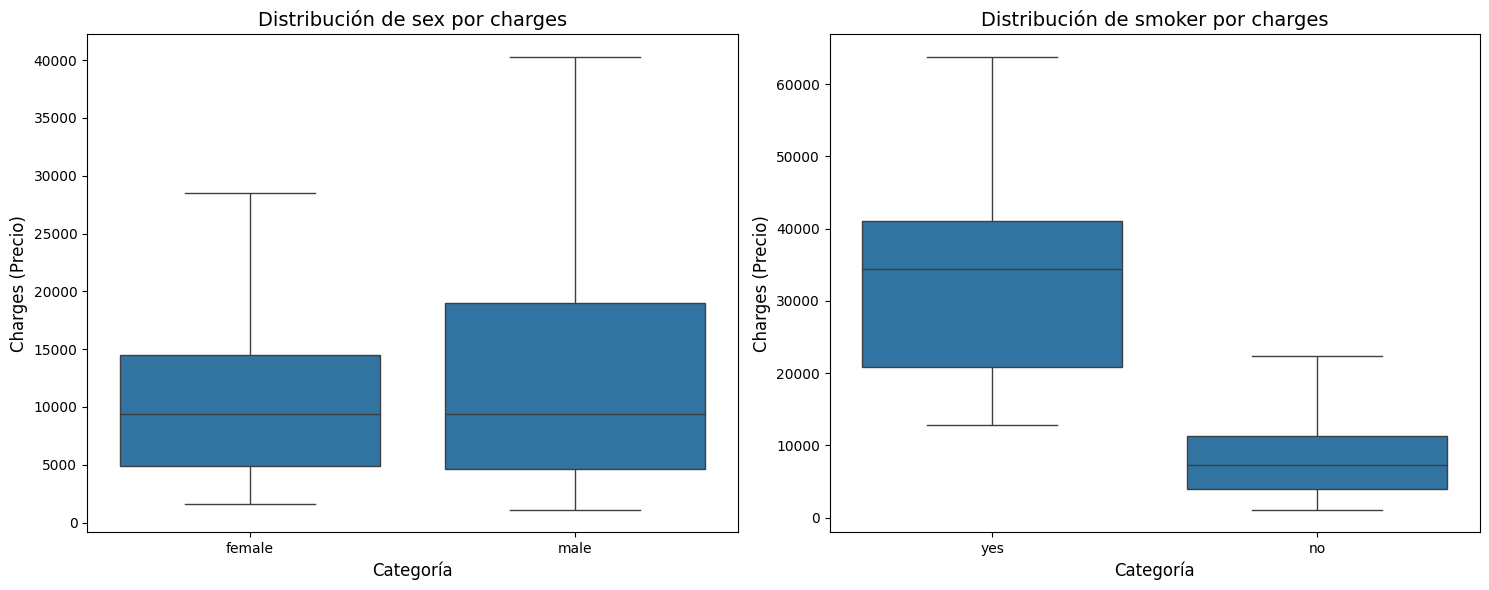

In [9]:
num_colum = ['sex', 'smoker']

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for i, col in enumerate(num_colum):

    sns.boxplot(data=df, x=col, y='charges',ax=axes[i], showfliers=False) 
    
    axes[i].set_title(f'Distribución de {col} por charges', fontsize=14)
    axes[i].set_xlabel('Categoría', fontsize=12)
    axes[i].set_ylabel('Charges (Precio)', fontsize=12)

plt.tight_layout()
plt.show()

## Variables númericas

> Las analizaremos directamente en la correlación una vez que factoricemos el data.

In [10]:
df['sex'].value_counts()

sex
male      675
female    662
Name: count, dtype: int64

In [11]:
df['sex_n'] = pd.factorize(df['sex'])[0]
df['sex_n'].value_counts()

sex_n
1    675
0    662
Name: count, dtype: int64

In [12]:
df['smoker'].value_counts()

smoker
no     1063
yes     274
Name: count, dtype: int64

In [13]:
df['smoker_n'] = pd.factorize(df['smoker'])[0]
df['smoker_n'].value_counts()

smoker_n
1    1063
0     274
Name: count, dtype: int64

In [14]:
# Creamos dos json donde ver que número se le ha asignado a cada categoría.
segmedico_sex = {row['sex']: row['sex_n'] for _, row in df.iterrows()}
segmedico_smoker = {row['smoker']: row['smoker_n'] for _, row in df.iterrows()}

In [15]:
with open('../data/processed/sex_segmedico.json', 'w') as file:
    json.dump(segmedico_sex, file)

with open('../data/processed/smoker_segmedico.json', 'w') as file:
    json.dump(segmedico_smoker, file)


In [16]:
df

,age,sex,bmi,children,smoker,charges,sex_n,smoker_n
0,19,female,27.900,0,yes,16884.92400,0,0
1,18,male,33.770,1,no,1725.55230,1,1
2,28,male,33.000,3,no,4449.46200,1,1
3,33,male,22.705,0,no,21984.47061,1,1
4,32,male,28.880,0,no,3866.85520,1,1
...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,10600.54830,1,1
1334,18,female,31.920,0,no,2205.98080,0,1
1335,18,female,36.850,0,no,1629.83350,0,1
1336,21,female,25.800,0,no,2007.94500,0,1


In [17]:
df_facto = df.copy()
df_facto.drop(['sex','smoker'], axis=1, inplace=True)
df_facto


,age,bmi,children,charges,sex_n,smoker_n
0,19,27.900,0,16884.92400,0,0
1,18,33.770,1,1725.55230,1,1
2,28,33.000,3,4449.46200,1,1
3,33,22.705,0,21984.47061,1,1
4,32,28.880,0,3866.85520,1,1
...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,1,1
1334,18,31.920,0,2205.98080,0,1
1335,18,36.850,0,1629.83350,0,1
1336,21,25.800,0,2007.94500,0,1


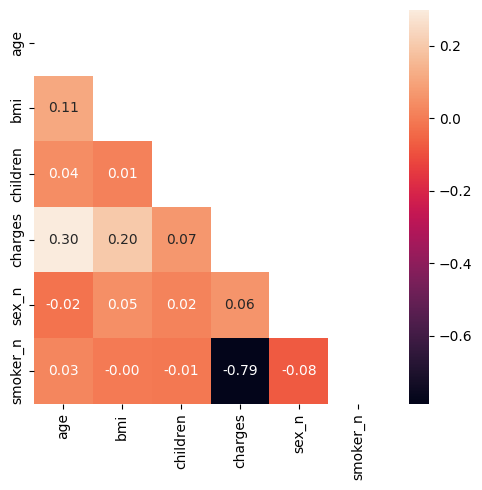

In [18]:
corr = df_facto.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, axis = plt.subplots(figsize=(5,5))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f")

plt.tight_layout()
plt.show()

> ### Observaciones
>La columna de fumador está muy correlacionada con mi target que es la prima del seguro.
Sabemos que si eres fumador el coste del seguro será más elevado. Totalmente necesaria para calcular el coste de la prima.

## Ingeniería de características.

En esta base de datos no tenemos ninguna columna que podamos unificar para hacer el data menos pesado.

In [19]:
# 1. Usamos el método .round() en la columna 'charges' para usar solo dos decimales.
df_facto['charges'] = df_facto['charges'].round(2)
df_facto['charges']

0       16884.92
1        1725.55
2        4449.46
3       21984.47
4        3866.86
          ...   
1333    10600.55
1334     2205.98
1335     1629.83
1336     2007.94
1337    29141.36
Name: charges, Length: 1337, dtype: float64

In [20]:
df_facto.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1337.0,39.222139,14.044333,18.00,27.00,39.00,51.00,64.00
bmi,1337.0,30.663452,6.100468,15.96,26.29,30.40,34.70,53.13
children,1337.0,1.095737,1.205571,0.00,0.00,1.00,2.00,5.00
charges,1337.0,13279.121503,12110.359677,1121.87,4746.34,9386.16,16657.72,63770.43
sex_n,1337.0,0.504862,0.500163,0.00,0.00,1.00,1.00,1.00
smoker_n,1337.0,0.795064,0.403806,0.00,1.00,1.00,1.00,1.00


## Split

In [21]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'charges', 'sex_n',
       'smoker_n'],
      dtype='object')

In [22]:
# Elimino las columnas que añadí factorizadas anteriormente

df.drop(['sex_n', 'smoker_n'], axis=1, inplace=True)

In [23]:
# Dividimos el conjunto de datos en muestras de train y test
X = df.drop('charges', axis=1)
y = df['charges']

# Instancia de: from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=18)

In [24]:
y_train

1154    11015.17470
1101    11253.42100
662      5148.55260
147      9877.60770
534     13831.11520
           ...     
1199     4934.70500
838      6402.29135
1145    11289.10925
275      9715.84100
1323    43896.37630
Name: charges, Length: 1069, dtype: float64

In [25]:
X_train.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker'], dtype='object')

In [26]:
y_test.shape

(268,)

In [27]:
X_train.head()

,age,sex,bmi,children,smoker
1154,48,female,27.93,4,no
1101,53,male,28.60,3,no
662,32,female,31.54,1,no
147,51,female,37.73,1,no
534,64,male,40.48,0,no


In [28]:
#convertimos en DF para poderlo guardar en csv.

X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)
y_train_df = pd.DataFrame(y_train)
y_test_df = pd.DataFrame(y_test)

In [29]:
# Guardar datasets procesados en data/processed

X_train_df.to_csv('../data/processed/X_train_segmed.csv', index=False)
X_test_df.to_csv('../data/processed/X_test_segmed.csv', index=False)
y_train_df.to_csv('../data/processed/y_train_segmed.csv', index=False)
y_test_df.to_csv('../data/processed/y_test_segmed.csv', index=False)

## Scaling y Encoding.

> ### Encoding
#### One-Hot Encoding

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 73.1+ KB


In [31]:
# Genero una lista con los nombres SOLO de las columnas categóricas
cat_variables = ['sex', 'smoker']

# Creamos la instancia del encoder
onehot_encoder = OneHotEncoder(sparse_output=False)

# Entrenamos el encoder con los datos de entrenamiento (ajustamos)
onehot_encoder.fit(X_train[cat_variables])

# Aplicamos el encoder en el conjunto de entrenamiento: X_train
X_train_cat_ohe = onehot_encoder.transform(X_train[cat_variables])
X_train_cat_ohe = pd.DataFrame(X_train_cat_ohe,
                               index=X_train.index,
                               columns=onehot_encoder.get_feature_names_out(cat_variables))

# Aplicamos el encoder en el conjunto de test: X_test
X_test_cat_ohe = onehot_encoder.transform(X_test[cat_variables])
X_test_cat_ohe = pd.DataFrame(X_test_cat_ohe,
                              index=X_test.index,
                              columns=onehot_encoder.get_feature_names_out(cat_variables))

X_train_cat_ohe.head()

,sex_female,sex_male,smoker_no,smoker_yes
1154,1.0,0.0,1.0,0.0
1101,0.0,1.0,1.0,0.0
662,1.0,0.0,1.0,0.0
147,1.0,0.0,1.0,0.0
534,0.0,1.0,1.0,0.0


> ### Escalado Mínimo-Máximo

In [32]:
min_max_scaler = MinMaxScaler()

# Genero una lista con los nombres SOLO de las columnas numéricas sin mi target.
num_variables = ['age', 'bmi', 'children']

min_max_features_train = min_max_scaler.fit_transform(X_train[num_variables])

df_min_max_train = pd.DataFrame(min_max_features_train,
                          index=X_train.index,
                          columns=num_variables)
df_min_max_train


,age,bmi,children
1154,0.652174,0.306072,0.8
1101,0.760870,0.324522,0.6
662,0.304348,0.405480,0.2
147,0.717391,0.575933,0.2
534,1.000000,0.651659,0.0
...,...,...,...
1199,0.282609,0.247418,0.4
838,0.369565,0.183120,0.4
1145,0.739130,0.439488,0.6
275,0.630435,0.269448,0.4


In [33]:
min_max_features_test = min_max_scaler.fit_transform(X_test[num_variables])

df_min_max_test = pd.DataFrame(min_max_features_test,
                          index=X_test.index,
                          columns=num_variables)
df_min_max_test

,age,bmi,children
381,0.804348,0.402103,0.0
38,0.369565,0.565538,0.2
197,0.586957,0.345167,0.4
14,0.195652,0.714637,0.0
94,1.000000,0.418897,0.4
...,...,...,...
978,0.586957,0.656335,0.6
1109,0.586957,0.119880,0.6
8,0.413043,0.378755,0.4
809,0.152174,0.269798,0.2


## Selección de características.

In [34]:
# Con un valor de k=5 queremos decir implícitamente que queremos eliminar 2 características del conjunto de datos
selection_model = SelectKBest(f_classif, k=5)

# Entreno el modelo mediante fit()
selection_model.fit(X_train_cat_ohe, y_train)

ix = selection_model.get_support()

# Aplico el modelo a los datos X_train y X_test del que hemos codificado a numérico (del One_hot Encoding)
X_train_sel  = selection_model.transform(X_train_cat_ohe)
X_test_sel = selection_model.transform(X_test_cat_ohe)

# Genero los dataframes
X_train_sel = pd.DataFrame(X_train_sel, columns=X_train_cat_ohe.columns.values[ix])
X_test_sel = pd.DataFrame(X_test_sel, columns=X_test_cat_ohe.columns.values[ix])

X_train_sel.head()

/home/vscode/.local/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:782: UserWarning: k=5 is greater than n_features=4. All the features will be returned.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:107: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)


,sex_female,sex_male,smoker_no,smoker_yes
0,1.0,0.0,1.0,0.0
1,0.0,1.0,1.0,0.0
2,1.0,0.0,1.0,0.0
3,1.0,0.0,1.0,0.0
4,0.0,1.0,1.0,0.0


In [35]:
X_test_sel

,sex_female,sex_male,smoker_no,smoker_yes
0,0.0,1.0,0.0,1.0
1,0.0,1.0,0.0,1.0
2,1.0,0.0,1.0,0.0
3,0.0,1.0,0.0,1.0
4,1.0,0.0,0.0,1.0
...,...,...,...,...
263,1.0,0.0,1.0,0.0
264,0.0,1.0,1.0,0.0
265,0.0,1.0,1.0,0.0
266,0.0,1.0,1.0,0.0


In [36]:
y_train

1154    11015.17470
1101    11253.42100
662      5148.55260
147      9877.60770
534     13831.11520
           ...     
1199     4934.70500
838      6402.29135
1145    11289.10925
275      9715.84100
1323    43896.37630
Name: charges, Length: 1069, dtype: float64

In [37]:
y_test

381     42303.69215
38      39774.27630
197      8516.82900
14      39611.75770
94      47291.05500
           ...     
978      9704.66805
1109     8605.36150
8        6406.41070
809      3309.79260
817      3597.59600
Name: charges, Length: 268, dtype: float64

## Machine Learning (Modelado)

In [38]:
def warn(*args, **kwargs):
    pass

warnings.warn = warn

In [39]:
model = LinearRegression(fit_intercept=True, copy_X=True, tol=1e-06, n_jobs=None, positive=False)


In [40]:
model.fit(X_train_sel, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [41]:
# Vemos el Intercepto
model.intercept_


np.float64(20618.16807979837)

In [42]:
# Vemos el Coeficiente
model.coef_

array([ 1.07730239e+01, -1.07730239e+01, -1.21339431e+04,  1.21339431e+04])

In [43]:
y_pred = model.predict(X_test_sel)
y_pred

array([32741.33819139, 32741.33819139,  8494.9979682 , 32741.33819139,
       32762.88423914,  8494.9979682 , 32741.33819139, 32741.33819139,
       32741.33819139, 32741.33819139,  8494.9979682 ,  8494.9979682 ,
        8494.9979682 ,  8494.9979682 ,  8494.9979682 ,  8494.9979682 ,
        8494.9979682 ,  8494.9979682 ,  8494.9979682 , 32741.33819139,
       32741.33819139,  8473.45192046,  8473.45192046,  8473.45192046,
        8494.9979682 ,  8494.9979682 , 32762.88423914,  8473.45192046,
        8494.9979682 , 32762.88423914,  8473.45192046,  8494.9979682 ,
        8494.9979682 ,  8494.9979682 ,  8494.9979682 ,  8494.9979682 ,
        8473.45192046, 32762.88423914,  8494.9979682 ,  8494.9979682 ,
        8494.9979682 , 32741.33819139,  8473.45192046, 32741.33819139,
       32762.88423914, 32762.88423914, 32762.88423914,  8494.9979682 ,
        8494.9979682 , 32741.33819139,  8494.9979682 ,  8473.45192046,
        8494.9979682 ,  8473.45192046,  8473.45192046,  8494.9979682 ,
      

In [44]:
#Intercepto
model.intercept_


np.float64(20618.16807979837)

In [45]:
#Coeficientes (b1, b2)
model.coef_

array([ 1.07730239e+01, -1.07730239e+01, -1.21339431e+04,  1.21339431e+04])

>Para calcular la efectividad del modelo utilizaremos el error cuadrático medio (MSE) y el coeficiente de determinación (R2), unas de las métricas más populares:

In [46]:
#Error cuadrático medio:
mean_squared_error(y_test, y_pred)


62556731.45912422

In [47]:
#Coeficiente de determinación: 
r2_score(y_test, y_pred)

0.5666785522004112

> Voy a ver si con train el coeficiente de determinación es mayor.

In [48]:
y_pred_train = model.predict(X_train_sel)
y_pred_train

array([ 8494.9979682 ,  8473.45192046,  8494.9979682 , ...,
        8473.45192046,  8494.9979682 , 32762.88423914], shape=(1069,))

In [51]:
#Coeficiente de determinación: 
r2_score(y_train, y_pred_train)

0.6319200626393044

> ## Conclusion final
>
>Nuestro modelo tiene un 57% de acierto, lo cual no es un % muy bueno, pero al hacerlo sobre train vemos que el % no es mucho mayor. 



> 2º Análisis exploratorio
> No es necesario, pero quiero hacerlo para verlo visualmente sobre dos variables.
> Utilizo diagrama de puntos se visualizará la relación entre la variable predictora y las variables objetivo.

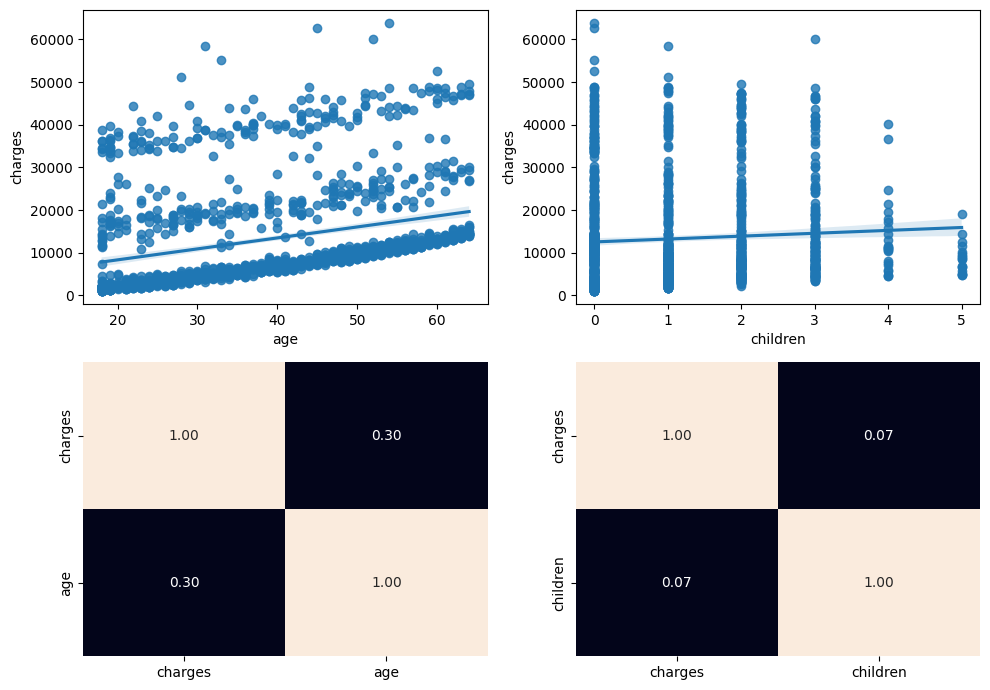

In [52]:
fig, axis = plt.subplots(2, 2, figsize = (10, 7))

sns.regplot(ax = axis[0, 0], data = df, x = "age", y = "charges")
sns.heatmap(df[["charges", "age"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 0], cbar = False)

sns.regplot(ax = axis[0, 1], data = df, x = "children", y = "charges")
sns.heatmap(df[["charges", "children"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 1], cbar = False)

plt.tight_layout()
plt.show()